In [1]:
import AdaNet_CIFAR_10_feature_extraction as AdaFE
import time
import importlib

In [24]:
importlib.reload(AdaFE)

<module 'AdaNet_CIFAR_10_feature_extraction' from 'C:\\Users\\David\\Documents\\דוקטורט\\קורס יישום אלגוריתמים לומדים 372.2.5214\\ex4\\adanet\\AdaNet_CIFAR_10_feature_extraction.py'>

In [25]:
# example implementation
# cat_dog = CF10_pairs('cat','dog')

# start_time = time.time()
# X_train, y_train, X_test, y_test = train_test_dataset(cat_dog)
# print(time.time() - start_time)

In [2]:
cat_dog = AdaFE.CF10_pairs('cat','dog')

In [3]:
start_time = time.time()
X_train, y_train, X_test, y_test = AdaFE.train_test_dataset(cat_dog)
print(time.time() - start_time)

0.22400879859924316


In [4]:
# Neural Network
#----------------------------------
#
#
# We will use the CIFAR-10 data, specifically:
#  y = 0 first class image or 1 = second class image
#  x = features we have extracted from the images HOG (Histogram Of Gradient features) and Color histograms
#
# reg_lambda (regularization) = [0, 10e-1, 10e-2, 10e-3, 10e-4, 10e-5]
# eta (learning rate) = [10e-1, 10e-2, 10e-3, 10e-4]
# hidden_layer_nodes (n, number of neurons in each layer) = [100, 150, 512, 1024, 2048]
# num_hidden_layers (l, number of hidden layers) = [1, 2, 3]

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.python.framework import ops
import os.path
import csv


ops.reset_default_graph()

# Create graph
sess = tf.Session()

In [5]:
# set for reproducible results
seed = 99
np.random.seed(seed)
tf.set_random_seed(seed)

In [6]:
# Split data into train/test = 80%/20%
#train_indices = np.random.choice(len(x_vals), round(len(x_vals)*0.8), replace=False)
#test_indices = np.array(list(set(range(len(x_vals))) - set(train_indices)))
x_vals_train = X_train
x_vals_test = X_test
y_vals_train = y_train
y_vals_test = y_test

In [7]:
###
# Define Tensorflow computational graph¶
###

# Declare batch size
hidden_layer_nodes = 100
batch_size = 100
reg_lambda = 0.1

# Initialize placeholders
x_data = tf.placeholder(shape=[None, 155], dtype=tf.float32)
y_target = tf.placeholder(shape=[None, 1], dtype=tf.float32)

# Create variables for both NN layers
A1 = tf.Variable(tf.random_normal(shape=[155,hidden_layer_nodes])) # inputs -> hidden nodes
b1 = tf.Variable(tf.random_normal(shape=[hidden_layer_nodes]))   # one biases for each hidden node
A2 = tf.Variable(tf.random_normal(shape=[hidden_layer_nodes,1])) # hidden inputs -> 1 output
b2 = tf.Variable(tf.random_normal(shape=[1]))   # 1 bias for the output


###############   b = tf.Variable(tf.random_normal(shape=[1,1]))  *** difference in shape 1 vs. 1,1

# Declare model operations
hidden_output = tf.nn.relu(tf.add(tf.matmul(x_data, A1), b1))
# No activation on final_output layer because the loss function will
# implement the last sigmoid necessary
final_output = tf.add(tf.matmul(hidden_output, A2), b2) 

# Declare loss function (Cross Entropy loss)
loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=final_output, labels=y_target))

# Loss function using L2 Regularization on each of the weights
regularizers = tf.nn.l2_loss(A1) + tf.nn.l2_loss(A2)
loss = tf.reduce_mean(loss + reg_lambda * regularizers)

# Declare optimizer
my_opt = tf.train.GradientDescentOptimizer(0.01)
train_step = my_opt.minimize(loss)

In [8]:
###
# Train model
###

# Initialize variables
init = tf.global_variables_initializer()
sess.run(init)

# Actual Prediction
prediction = tf.round(tf.sigmoid(final_output))
predictions_correct = tf.cast(tf.equal(prediction, y_target), tf.float32)
accuracy = tf.reduce_mean(predictions_correct)

In [13]:
# Training loop
loss_vec = []
train_acc = []
test_acc = []
for i in range(1500):
    rand_index = np.random.choice(len(x_vals_train), size=batch_size)
    rand_x = x_vals_train[rand_index]
    rand_y = y_vals_train[rand_index]  # shape should be y=[?,1] if y=[?,] have to convert by np.transpose([y_vals_train[rand_index]])
    sess.run(train_step, feed_dict={x_data: rand_x, y_target: rand_y})

    temp_loss = sess.run(loss, feed_dict={x_data: rand_x, y_target: rand_y})
    loss_vec.append(temp_loss)
    temp_acc_train = sess.run(accuracy, feed_dict={x_data: x_vals_train, y_target: y_vals_train})
    train_acc.append(temp_acc_train)
    temp_acc_test = sess.run(accuracy, feed_dict={x_data: x_vals_test, y_target: y_vals_test})
    test_acc.append(temp_acc_test)
    if (i+1)%300==0:
        print('Loss = ' + str(temp_loss))

Loss = 231.6317
Loss = 127.27612
Loss = 70.04684
Loss = 38.725494
Loss = 21.51501


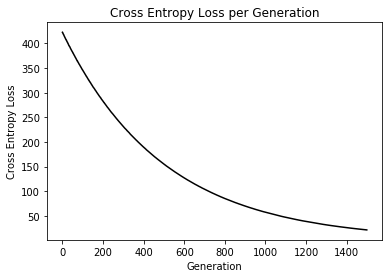

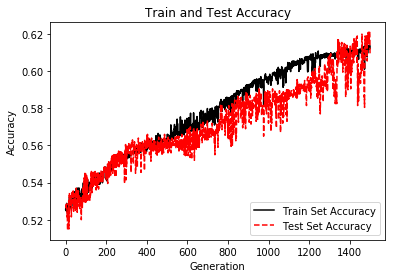

In [14]:
###
# Display model performance
###

# Plot loss over time
plt.plot(loss_vec, 'k-')
plt.title('Cross Entropy Loss per Generation')
plt.xlabel('Generation')
plt.ylabel('Cross Entropy Loss')
plt.show()

# Plot train and test accuracy
plt.plot(train_acc, 'k-', label='Train Set Accuracy')
plt.plot(test_acc, 'r--', label='Test Set Accuracy')
plt.title('Train and Test Accuracy')
plt.xlabel('Generation')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

In [ ]:
# Normalize by column (min-max norm)
def normalize_cols(m):
    col_max = m.max(axis=0)
    col_min = m.min(axis=0)
    return (m-col_min) / (col_max - col_min)
    
x_vals_train = np.nan_to_num(normalize_cols(x_vals_train))
x_vals_test = np.nan_to_num(normalize_cols(x_vals_test))